# Imports

In [17]:
%load_ext google.cloud.bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/rodrigoeji/sandbox/keys/galena-web-adea43fba8c1.json"

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [19]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
# np.set_printoptions(threshold=1000)

In [8]:

# Perfil A, B, C e D
# Baixo raciocínio
# Baixa aderência à carreira

# Indicador de raciocínio (*) [trazer faixas: baixo, médio, alto]
# Indicador de aderência a vendas (*) [trazer faixas: baixo, médio, alto]
# Tipos de Experiência profissional (Binário)
# Variáveis da entrevista ()


# Variáveis isoladas (*)
# Perfis Clusterizados (composição das variáveis explicativas)
# Perfil de Risco ML (interview) (*)
# Perfil Heurístico de Admissão (Estratégia T4) (*)
# Perfil Heurístico de Admissão (Estratégia T3)

# Variáveis de Sucesso:
# Performance no Quiz (*)
# Retenção/Evasão
# Farol de empregabilidade / indicações para o Comitê
# Performance na Avaliação 360
# Elencar 2-3 competências prioritárias, mas vamos dar uma olhada em todas :wink:
# Camilinha (sugestão): comunicação, colaboração e comprometimento



# Variáveis de Recorte:
# Gênero + Orientação sexual
# Raça
# Região


# Day: elencar de forma quali quais são os Galeners que não estão desempenhando tão bem (e por quê?); quais são os Galeners que são destaque.


# DFs

In [ ]:
entrevistas_t2 = pd.read_csv('entrevistas_turma_2.csv').rename(columns = {'E-mail candidate': 'personal_email', 'Status do Screening': 'status'})
entrevistas_t2 = entrevistas_t2[entrevistas_t2['status'] == "Indico"]
entrevistas_t2 = entrevistas_t2[['personal_email', "e9_verbal_communication", "e10_articulation", "e1_trajectory", "e3_resilience", "e5_family_support", "e7_financial_organization", "e6_study_organization", "e8_sales_motivation"]]
turma2 = pd.read_csv('groups_t2.csv')
turma3 = pd.read_csv('groups_t3.csv').merge(afs[['subscription_uuid', 'applicant_id']], on = 'subscription_uuid', how = 'inner')[['applicant_id', 'group']].drop_duplicates()

In [237]:
%%bigquery afs
select *, cast(student_created_at as date) as student_created_at_date
from `galena-web.inclusion.applicant_funnel_snapshot`

Downloading: 100%|███████████████████████████████████████| 35992/35992 [00:04<00:00, 8284.97rows/s]


In [ ]:
%%bigquery assessments
select * 
from `galena-web.program_2.assessments_results`

In [ ]:
%%bigquery assessments_competence

select applicant_id, 
        competence_code, 
        competence_title, 
        avg(assessment_valuePairs) as pairs, 
        avg(assessment_valueSelf) as self, 
        avg(assessment_valueStaffMonitor) as monitor, 
        avg(assessment_valuePairs_Monitor) as pairs_monitor, 
        avg(assessment_value) as overall
from `galena-web.program_2.assessments_results`
group by applicant_id, competence_code, competence_title

In [ ]:
%%bigquery irm_applicants
select distinct applicant_id
from `galena-web.inclusion.interview_results_model` 

In [ ]:
%%bigquery assessments_applicant
with db as (
select applicant_id, 
        avg(assessment_valuePairs) as pairs, 
        avg(assessment_valueSelf) as self, 
        avg(assessment_valueStaffMonitor) as monitor, 
        avg(assessment_valuePairs_Monitor) as pairs_monitor, 
        avg(assessment_value) as overall,

        
from `galena-web.program_2.assessments_results`
group by applicant_id
)

,db_final as (select distinct *,
        cast(pairs*2.0 as int)/2 as pairs_band,
        cast(self*2.0 as int)/2 as self_band,
        cast(monitor*2.0 as int)/2 as monitor_band,
        cast(pairs_monitor*2.0 as int)/2 as pairs_monitor_band,
        cast(overall*2.0 as int)/2 as overall_band
from db
             )

select db_final.* 
from db_final
inner join (select distinct applicant_id from `galena-web.inclusion.applicant_funnel_snapshot` where in_profile = 1 and interviewed = True and student_created_at is not null) in_profile
on db_final.applicant_id = in_profile.applicant_id


In [ ]:
assessments_applicant = assessments_applicant.drop_duplicates()

In [ ]:
%%bigquery irm
select db.applicant_id
from `galena-web.inclusion.interview_results_model` db
inner join (select distinct applicant_id from `galena-web.inclusion.applicant_funnel_snapshot` where in_profile = 1 and interviewed = True and student_created_at is not null) in_profile
on db.applicant_id = in_profile.applicant_id

In [ ]:
# DF

In [238]:
%%bigquery df

with interviews as (

        # general info
        select applicant_id,
               case when student_id is not null then 1 else 0 end as student_created,
               subscription_uuid,
        # logic_test_score_band
               logic_test_score,
               case when logic_test_score >= 64.28 then "5.alto"
                    when logic_test_score >= 58.85 then "4.medio-alto"
                    when logic_test_score >= 42.85 then "3.medio"
                    when logic_test_score >= 30 then "2.medio-baixo"
                    when logic_test_score >= 0 then "1.baixo"
                    else null end as logic_test_score_band,
        # sales_cs_adhesion_score_band
               sales_cs_adhesion_score,
               cast(sales_cs_adhesion_score/10 as int)*10 as sales_cs_adhesion_score_band,
        # experience
               case when i6_formal_experience is null then 0 else i6_formal_experience end as i6_formal_experience,
               case when i7_informal_experience is null then 0 else i7_informal_experience end as i7_informal_experience,
               case when i9_extracurricular_courses is null then 0 else i9_extracurricular_courses end as i9_extracurricular_courses,
               case when i10_sales_experience is null then 0 else i10_sales_experience end as i10_sales_experience,
        # media_screening
                case when interviewed = True then
                (case when e1_trajectory is null then 1 else e1_trajectory end
                + case when e2_commitment is null then 1 else e2_commitment end
                + case when e3_resilience is null then 1 else e3_resilience end
                + case when e4_proactivity is null then 1 else e4_proactivity end
                + case when e5_family_support is null then 1 else e5_family_support end
                + case when e6_study_organization is null then 1 else e6_study_organization end
                + case when e7_financial_organization is null then 1 else e7_financial_organization end
                + case when e8_sales_motivation is null then 1 else e8_sales_motivation end
                + case when e9_verbal_communication is null then 1 else e9_verbal_communication end
                + case when e10_articulation is null then 1 else e10_articulation end)/10
                else null end as media_screening,
        # reference_points_gp1
                (case when i6_formal_experience is null then 0 else i6_formal_experience end
                 + case when i7_informal_experience is null then 0 else i7_informal_experience end 
                 + case when i9_extracurricular_courses is null then 0 else i9_extracurricular_courses end) as reference_points_gp1,
        # experience_points_gp2
                (case when i6_formal_experience = 1 then 2
                      when i7_informal_experience = 1 then 1
                      else 0 end 
                 + case when i9_extracurricular_courses is null then 0 else i9_extracurricular_courses end 
                 + case when i10_sales_experience is null then 0 else i10_sales_experience end) as experience_points_gp2
        from `galena-web.inclusion.interview_results_model` 
)

,db as (

        select *,
               cast(media_screening as int) as media_screening_band,
        # reference_points_gp2
               case when media_screening >= 2.2 then 1 else 0 end
               + case when experience_points_gp2 > 2 then 1 else 0 end
               + case when sales_cs_adhesion_score >= 50 then 1 else 0 end
               + case when logic_test_score >= 58.85 then 1 else 0 end
               as reference_points_gp2
        from interviews 
)


select *,
        # gp1
        case when media_screening < 2.0 then "D"
            when media_screening >= 2.5 and reference_points_gp1 >= 2 then "A"
            when media_screening >= 2.0 and reference_points_gp1 >= 2  then "B"
            when media_screening >= 2.0 and reference_points_gp1 >= 1  then "C"
             else null end as gp1,
        # gp2
        case when reference_points_gp2 = 4 then "A" 
            when reference_points_gp2 = 3 then "B" 
            when reference_points_gp2 = 2 then "C" 
            when media_screening >= 19 and experience_points_gp2 > 1 and sales_cs_adhesion_score >= 40 and logic_test_score >= 42.85 then "D"
            else "E" end as gp2
from db

Downloading: 100%|█████████████████████████████████████████| 3898/3898 [00:01<00:00, 2642.01rows/s]


In [ ]:
df_applicant = assessments_competence\
.merge(turma3, on = 'applicant_id', how = 'inner')\
.merge(irm_bands, on = 'applicant_id', how = 'inner')
df_applicant[['group_grades', 'applicant_id']].drop_duplicates().groupby('group_grades').count()

# Analysis 360

## Functions

In [314]:
def interviews_360(answer_variable, interview_inputs) : 
# declaring
    df_aux = irm_bands
    assessments_db = assessments_applicant\
    .merge(turma3, on = 'applicant_id', how = 'left')\
    .merge(df_aux, on = 'applicant_id', how = 'left')
    assessments_db = assessments_db[~assessments_db[interview_inputs].isnull()]
    assessments_db[interview_inputs] = assessments_db[interview_inputs].astype('str')

# denominator
    denominator = assessments_db\
    .groupby(interview_inputs).applicant_id.count().reset_index()
    denominator['denominator'] = denominator['applicant_id']
    denominator = denominator[[interview_inputs, 'denominator']]
# numerator
    numerator = assessments_db\
    .groupby([interview_inputs, answer_variable]).applicant_id.count().reset_index()
    numerator['numerator'] = numerator['applicant_id']
    numerator = numerator[[interview_inputs, answer_variable, 'numerator']]

# final_df
    final_df = numerator.merge(denominator, on = interview_inputs, how = 'left')
    final_df['pct'] = final_df['numerator']/final_df['denominator']
    # final_df = final_df[final_df['denominator'] >= 10]  

# plot/return
    # return(final_df)
    final_df_pct = final_df.pivot(index = answer_variable, columns = interview_inputs, values = 'pct').fillna(0)
    final_df_pct.plot(figsize = (10, 7))
    # return(final_df)

In [315]:
def interviews_360_avg(answer_variable, interview_inputs) : 
# declaring
    df_applicant = assessments_applicant
    df_aux = irm_bands
    assessments_db = df_applicant\
    .merge(turma3, on = 'applicant_id', how = 'left')\
    .merge(df_aux, on = 'applicant_id', how = 'left')
    assessments_db = assessments_db[~assessments_db[interview_inputs].isnull()]

# sample_control
    sample_control = assessments_db\
    .groupby(interview_inputs).applicant_id.count().reset_index()
    sample_control = sample_control[sample_control['applicant_id'] >= 10]
    sample_control = sample_control[[interview_inputs]]
    
# plot/return
    final_df = assessments_db[[answer_variable, interview_inputs]].groupby(interview_inputs).mean(answer_variable)
    final_df.plot(figsize = (10, 5), kind = 'bar')
    # return(final_df)

In [316]:
def interviews_360_avg_compare_detail(interview_inputs, competence_title) : 
# declaring
    df_applicant = assessments_competence
    df_aux = irm_bands
    assessments_db = df_applicant\
    .merge(turma3, on = 'applicant_id', how = 'left')\
    .merge(df_aux, on = 'applicant_id', how = 'left')
    assessments_db = assessments_db[assessments_db['competence_title'] == competence_title]
    # assessments_db = assessments_db[~assessments_db[interview_inputs].isnull()]

# sample_control
    sample_control = assessments_db\
    .groupby([interview_inputs, 'competence_title']).applicant_id.count().reset_index()
    sample_control = sample_control[sample_control['applicant_id'] >= 10]
    sample_control = sample_control[[interview_inputs]]
    
# plot/return
    final_df = assessments_db[['self', 'pairs', 'monitor', 'competence_title', interview_inputs]].groupby([interview_inputs, 'competence_title']).mean() 
    final_df.plot(figsize = (10, 5), kind = 'bar')
    # return(final_df)

In [317]:
def interviews_360_avg_compare(interview_inputs) : 
# declaring
    df_applicant = assessments_applicant
    df_aux = irm_bands
    assessments_db = df_applicant\
    .merge(turma3, on = 'applicant_id', how = 'left')\
    .merge(df_aux, on = 'applicant_id', how = 'left')
    assessments_db = assessments_db[~assessments_db[interview_inputs].isnull()]

# sample_control
    sample_control = assessments_db\
    .groupby(interview_inputs).applicant_id.count().reset_index()
    sample_control = sample_control[sample_control['applicant_id'] >= 10]
    sample_control = sample_control[[interview_inputs]]
    
# plot/return
    final_df = assessments_db[['self', 'pairs', 'monitor', interview_inputs]].groupby(interview_inputs).mean() 
    final_df.plot(figsize = (10, 5), kind = 'bar')
    # return(final_df)

In [318]:
def interviews_360_median_compare(interview_inputs) : 
# declaring
    df_applicant = assessments_applicant
    df_aux = irm_bands
    assessments_db = df_applicant\
    .merge(turma3, on = 'applicant_id', how = 'left')\
    .merge(df_aux, on = 'applicant_id', how = 'left')
    assessments_db = assessments_db[~assessments_db[interview_inputs].isnull()]

# sample_control
    sample_control = assessments_db\
    .groupby(interview_inputs).applicant_id.count().reset_index()
    sample_control = sample_control[sample_control['applicant_id'] >= 10]
    sample_control = sample_control[[interview_inputs]]
    
# plot/return
    final_df = assessments_db[['self', 'pairs', 'monitor', interview_inputs]].groupby(interview_inputs).median() 
    final_df.plot(figsize = (10, 5), kind = 'bar')
    return(final_df)

In [319]:
def interviews_360_avg_compare_v2(interview_inputs) : 
# declaring
    df_applicant = assessments_applicant
    df_aux = irm_bands
    assessments_db = df_applicant\
    .merge(turma3, on = 'applicant_id', how = 'left')\
    .merge(df_aux, on = 'applicant_id', how = 'left')
    assessments_db = assessments_db[~assessments_db[interview_inputs].isnull()]

# sample_control
    sample_control = assessments_db\
    .groupby(interview_inputs).applicant_id.count().reset_index()
    sample_control = sample_control[sample_control['applicant_id'] >= 10]
    sample_control = sample_control[[interview_inputs]]
    
# plot/return
    final_df = assessments_db[['self', 'pairs_monitor', interview_inputs]].groupby(interview_inputs).mean()
    final_df.plot(figsize = (10, 5), kind = 'bar')
    return(final_df)

In [320]:
def interviews_360_count_compare(interview_inputs) : 
# declaring
    df_applicant = assessments_applicant
    df_aux = irm_bands
    assessments_db = df_applicant\
    .merge(turma3, on = 'applicant_id', how = 'left')\
    .merge(df_aux, on = 'applicant_id', how = 'left')
    assessments_db = assessments_db[~assessments_db[interview_inputs].isnull()]

# sample_control
    sample_control = assessments_db\
    .groupby(interview_inputs).applicant_id.count().reset_index()
    sample_control = sample_control[sample_control['applicant_id'] >= 10]
    sample_control = sample_control[[interview_inputs]]
    
# plot/return
    final_df = assessments_db[['self', 'pairs', 'monitor', interview_inputs]].groupby(interview_inputs).count() 
    final_df.plot(figsize = (10, 5), kind = 'bar')
    return(final_df)

## Analysis

In [321]:
# inputs

lista_screening = ["media_screening_band",
                   "media_screening_quartile",
                   "e1_trajectory",
                   "e2_commitment",
                   "e3_resilience",
                   "e4_proactivity",
                   "e5_family_support",
                   "e6_study_organization",
                   "e7_financial_organization",
                   "e8_sales_motivation",
                   "e9_verbal_communication",
                   "e10_articulation"]

lista_screening_modified = ["media_screening_band",
                            "media_screening_quartile",
                            "e1_trajectory_modified",
                            "e2_commitment_modified",
                            "e3_resilience_modified",
                            "e4_proactivity_modified",
                            "e5_family_support_modified",
                            "e6_study_organization_modified",
                            "e7_financial_organization_modified",
                            "e8_sales_motivation_modified",
                            "e9_verbal_communication_modified",
                            "e10_articulation_modified"]

list_tests = ['logic_test_score_band', 
              'sales_cs_adhesion_score_band',
              'media_screening_band']

interview_inputs_list = ['i6_formal_experience',
                         'i7_informal_experience',
                         'i9_extracurricular_courses']

interview_inputs_list_2 = ['group',
                           'i6_formal_experience',
                           'i7_informal_experience',
                           'i9_extracurricular_courses']

# output
list_360_bands = ['pairs_band',
                  'self_band',
                  'monitor_band',
                  'pairs_monitor_band',
                  'overall_band']

list_360 = ['pairs',
            'self',
            'monitor',
            'pairs_monitor',
            'overall']




In [71]:
irm_bands.describe()

,applicant_id,student_created,logic_test_score,sales_cs_adhesion_score,sales_cs_adhesion_score_band,i6_formal_experience,i7_informal_experience,i9_extracurricular_courses,i10_sales_experience,media_screening,e1_trajectory,e2_commitment,e3_resilience,e4_proactivity,e5_family_support,e6_study_organization,e7_financial_organization,e8_sales_motivation,e9_verbal_communication,e10_articulation,e1_trajectory_modified,e2_commitment_modified,e3_resilience_modified,e4_proactivity_modified,e5_family_support_modified,e6_study_organization_modified,e7_financial_organization_modified,e8_sales_motivation_modified,e9_verbal_communication_modified,e10_articulation_modified,reference_points_gp1,experience_points_gp2,aux_count,media_screening_group,media_screening_band
count,153.000000,153.0,151.000000,151.000000,151.000000,153.000000,153.000000,153.000000,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,153.000000,153.000000,153.0,153.000000,153.000000
mean,14877.150327,1.0,53.358562,54.078497,54.635762,0.627451,0.588235,0.718954,0.0,2.391503,2.169935,2.281046,2.294118,2.333333,2.490196,2.424837,2.346405,2.176471,2.614379,2.784314,1.211921,1.311258,1.298013,1.344371,1.549669,1.437086,1.364238,1.205298,1.602649,1.781457,1.934641,2.209150,1.0,2.209150,2.405229
std,5626.296171,0.0,21.156494,13.406302,13.553589,0.485071,0.493769,0.450986,0.0,0.391345,0.497240,0.505984,0.583573,0.584898,0.698849,0.558344,0.641957,0.501546,0.597409,0.549416,0.410029,0.464549,0.458907,0.476744,0.499183,0.497677,0.482817,0.405263,0.490978,0.414633,0.816549,0.870976,0.0,0.957337,0.555332
min,124.000000,1.0,8.571429,17.853896,20.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,1.000000
25%,11530.000000,1.0,37.142857,45.604312,50.000000,0.000000,0.000000,0.000000,0.0,2.100000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.0,1.000000,2.000000
50%,15251.000000,1.0,52.857143,55.755828,60.000000,1.000000,1.000000,1.000000,0.0,2.400000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.0,2.000000,2.000000
75%,20067.000000,1.0,69.285714,62.772145,60.000000,1.000000,1.000000,1.000000,0.0,2.600000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,1.0,3.000000,3.000000
max,22826.000000,1.0,100.000000,86.268898,90.000000,1.000000,1.000000,1.000000,0.0,3.800000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,1.0,4.000000,4.000000


In [364]:
x = assessments_applicant\
.merge(turma3, on = 'applicant_id', how = 'left')\
.merge(irm_bands, on = 'applicant_id', how = 'left')

In [365]:
x.groupby('group').count()[['applicant_id']]

,applicant_id
group,
A,47
B,72
C,16
D,2


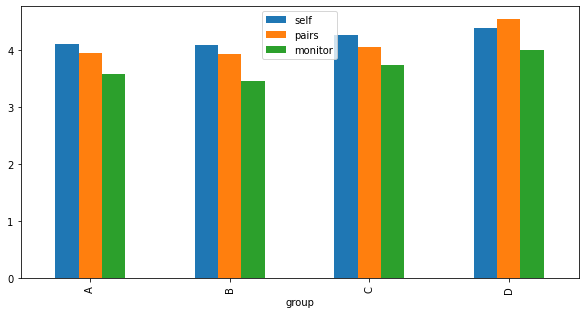

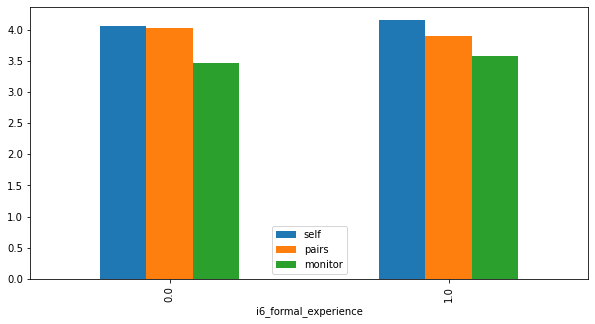

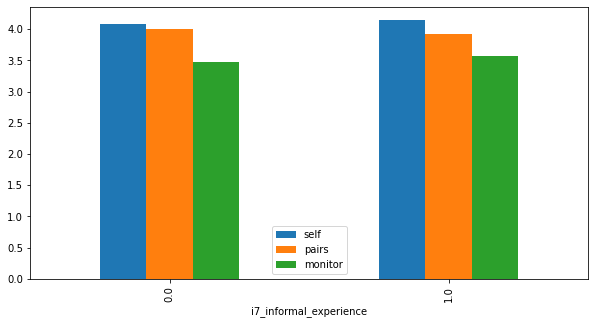

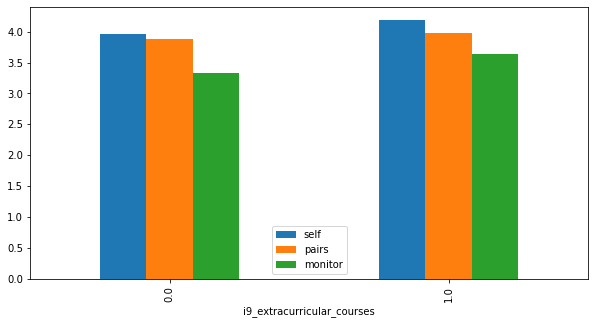

In [323]:
for interview_inputs in interview_inputs_list_2 :
    interviews_360_avg_compare(interview_inputs)

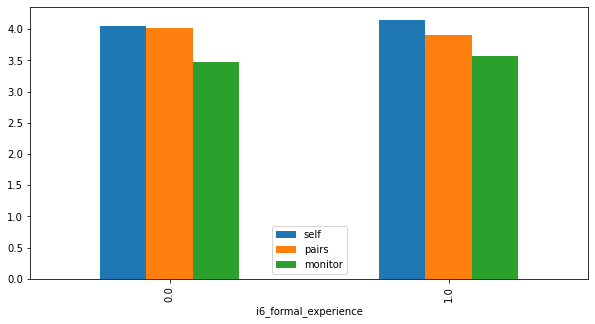

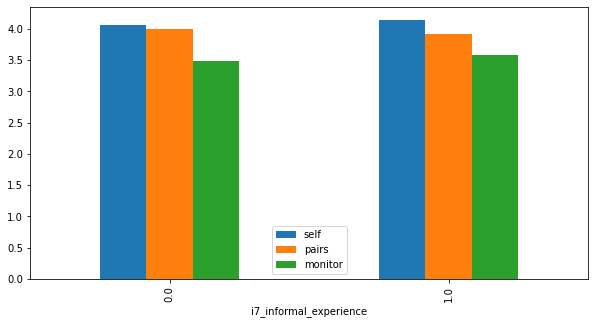

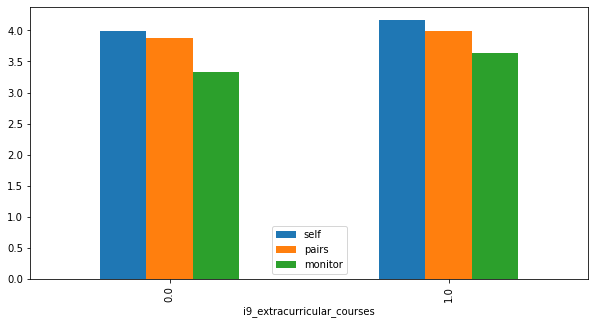

In [165]:
for interview_inputs in interview_inputs_list :
    interviews_360_avg_compare(interview_inputs)

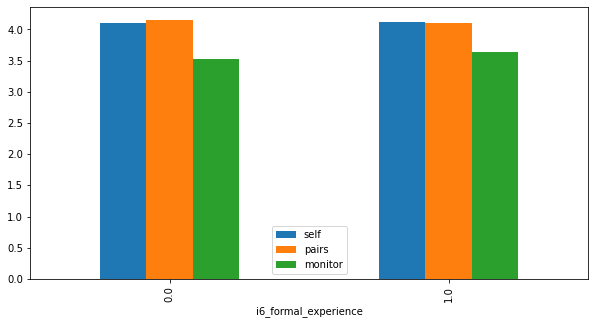

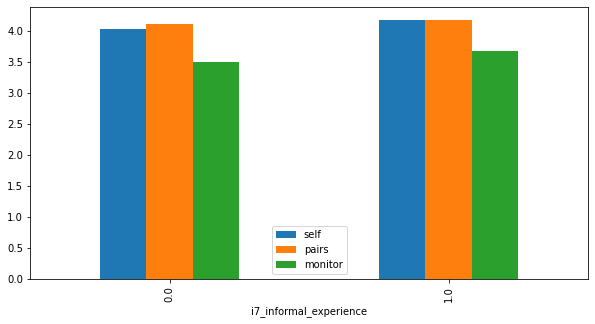

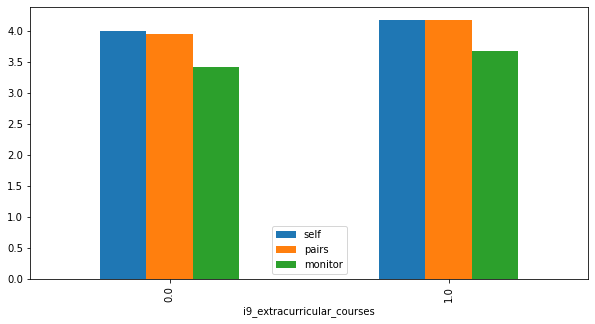

In [166]:
for interview_inputs in interview_inputs_list :
    interviews_360_median_compare(interview_inputs)

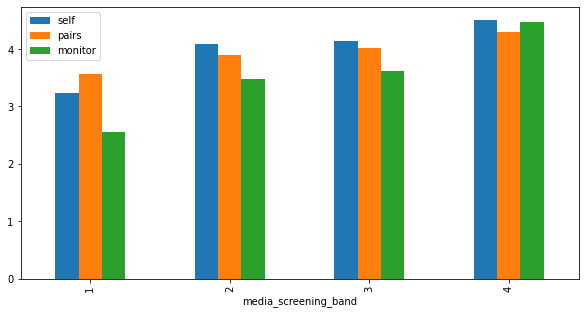

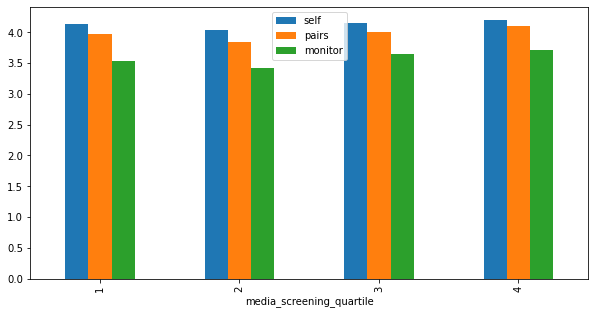

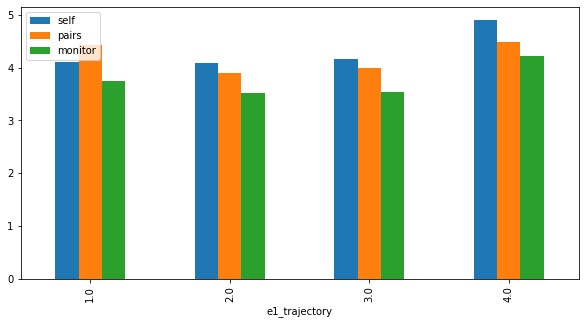

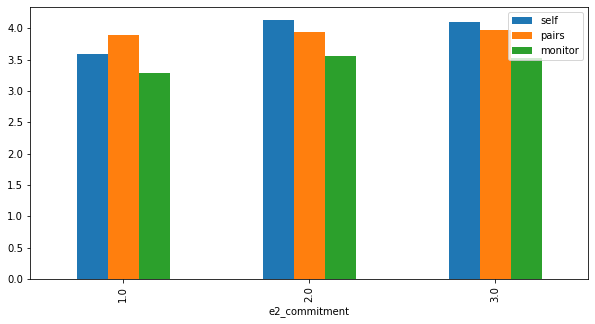

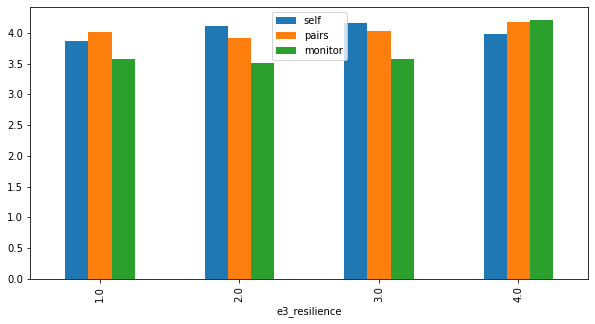

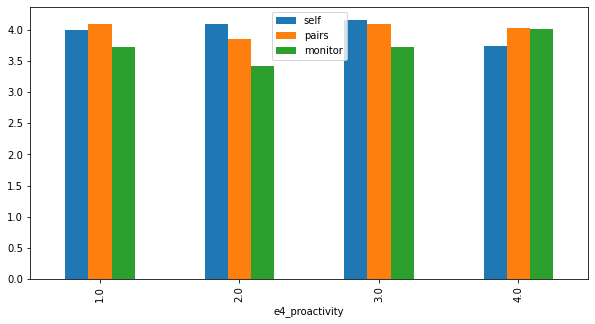

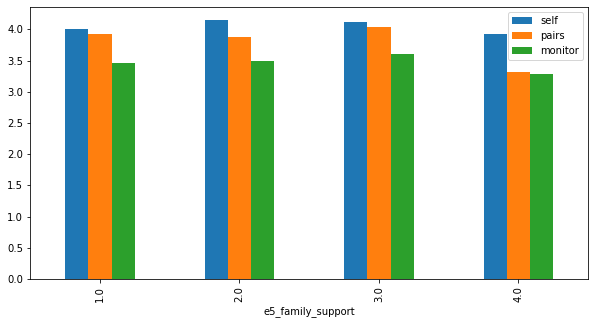

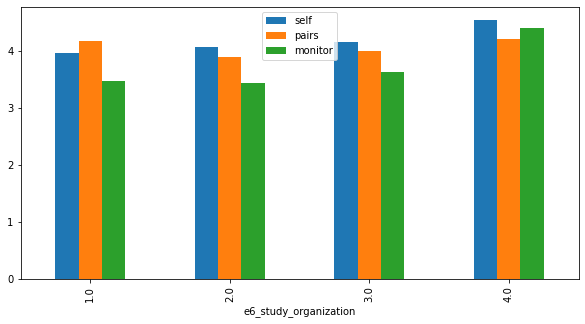

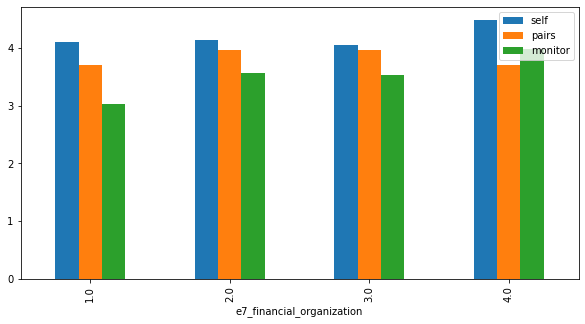

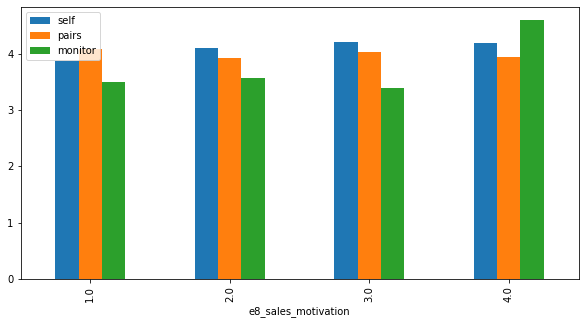

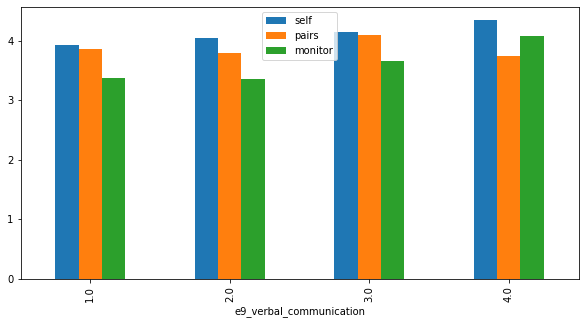

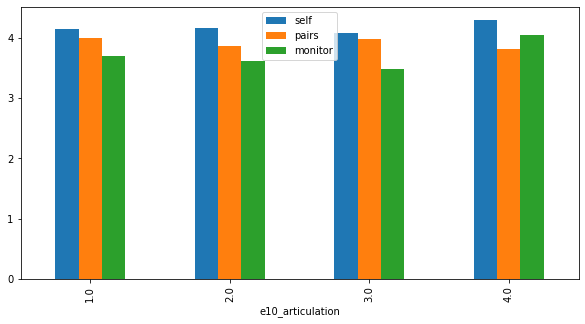

In [167]:
for interview_inputs in lista_screening :
    interviews_360_avg_compare(interview_inputs)

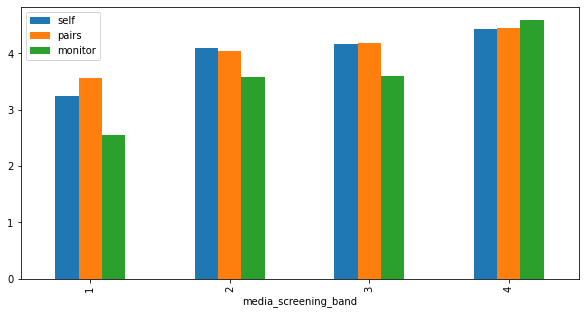

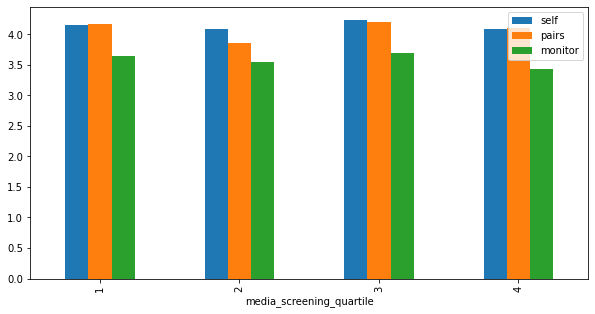

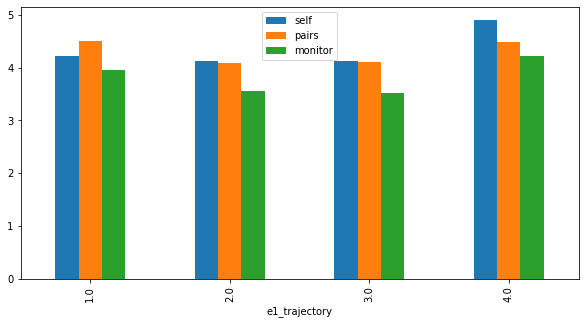

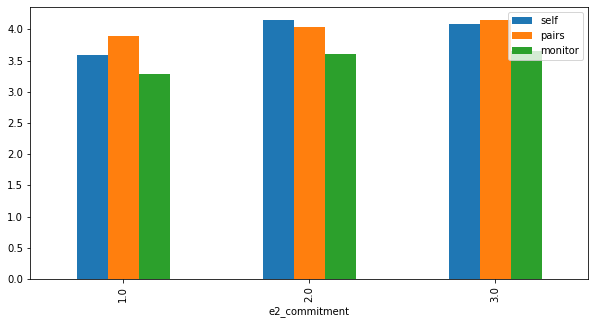

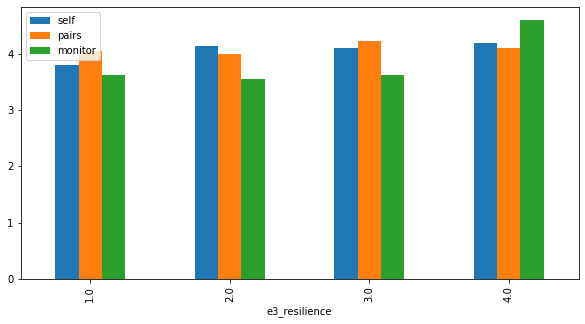

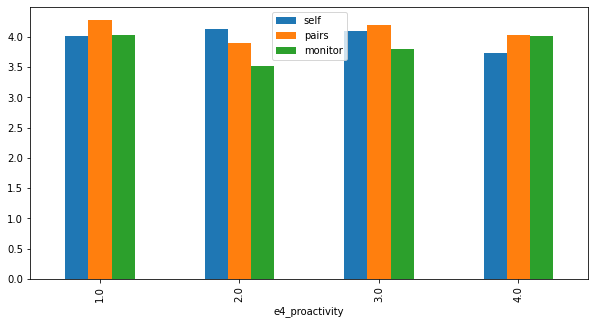

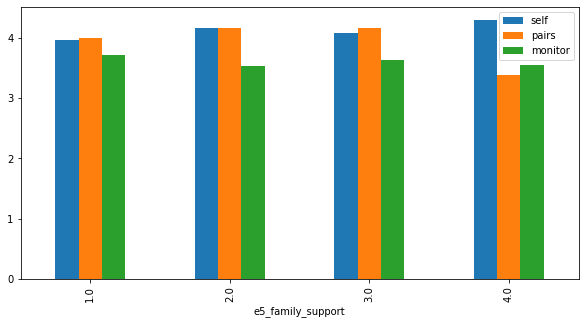

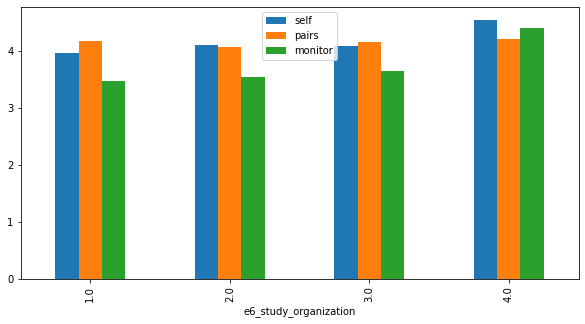

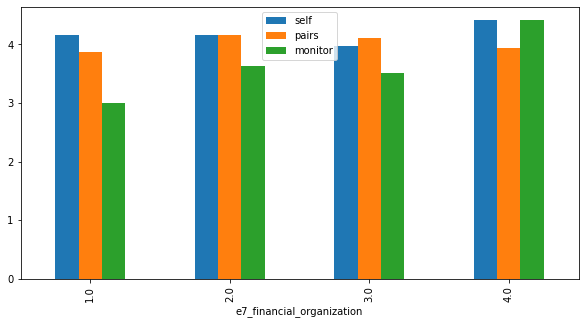

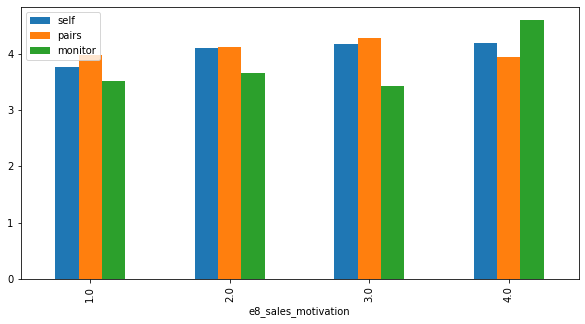

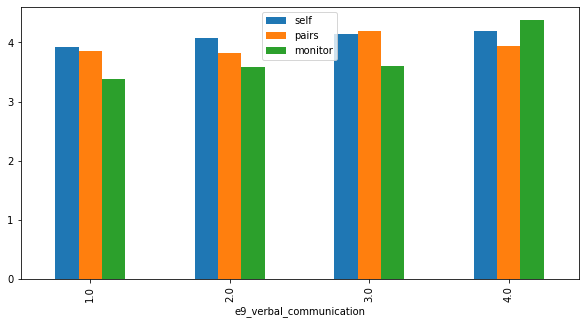

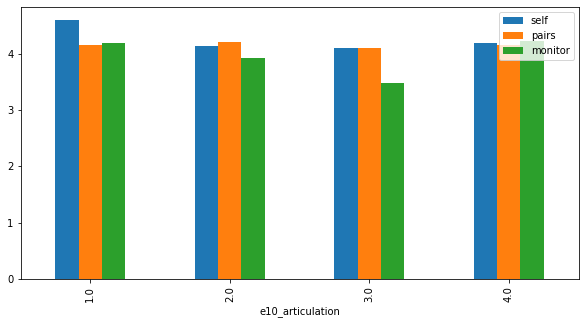

In [168]:
for interview_inputs in lista_screening :
    interviews_360_median_compare(interview_inputs)

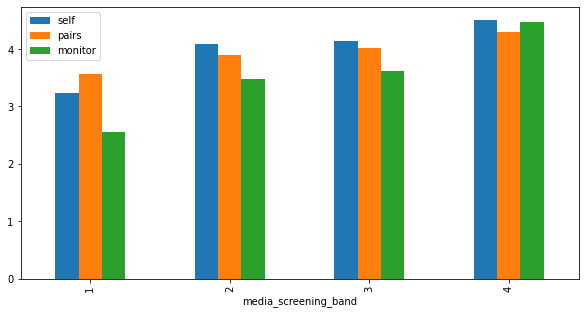

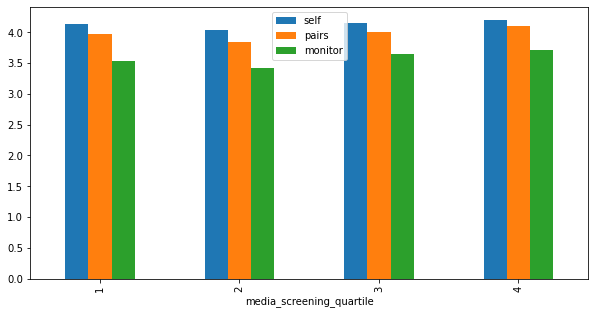

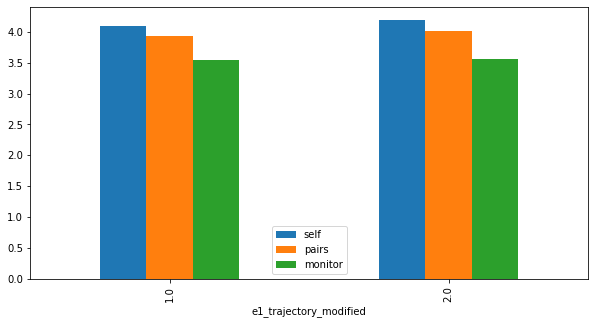

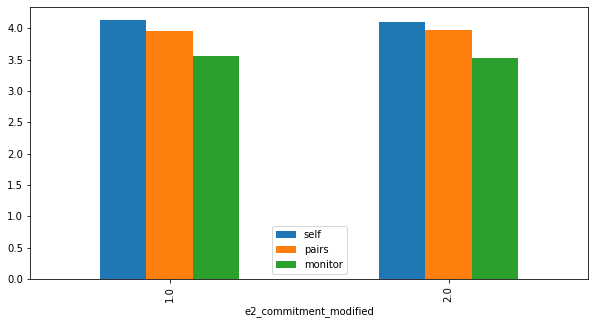

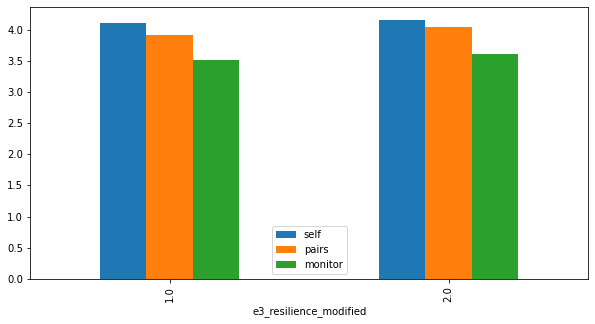

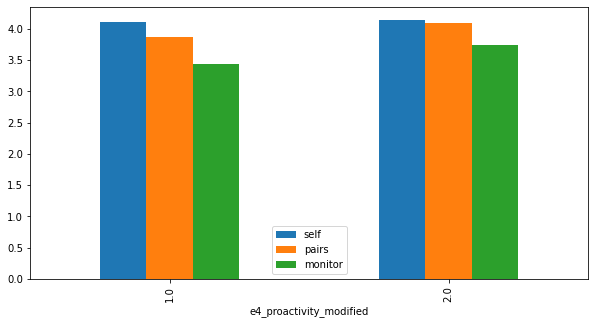

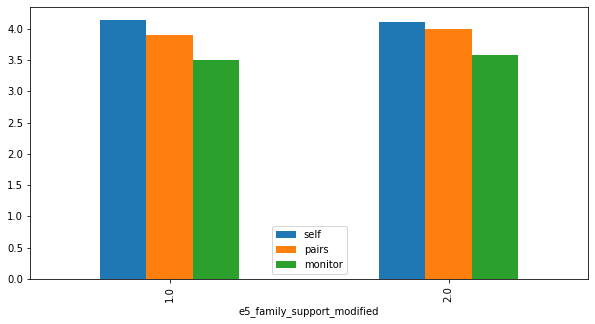

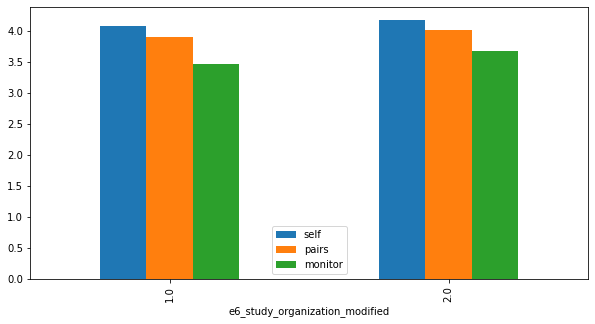

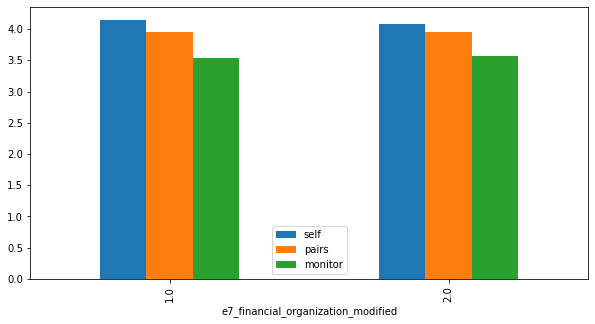

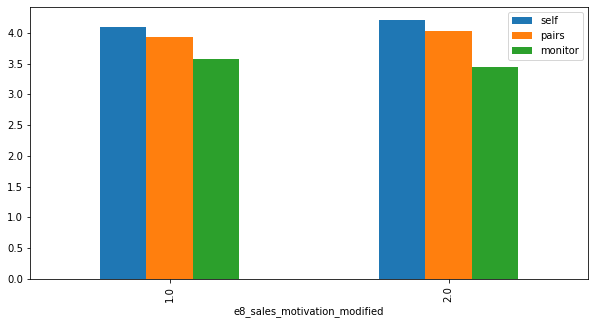

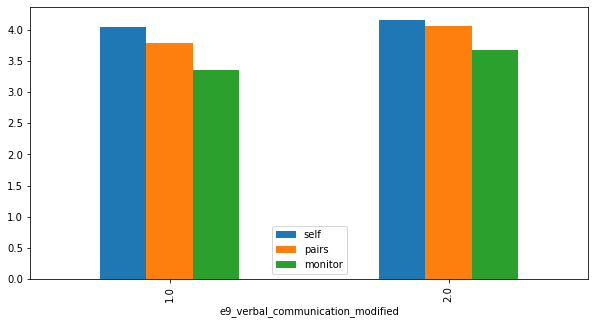

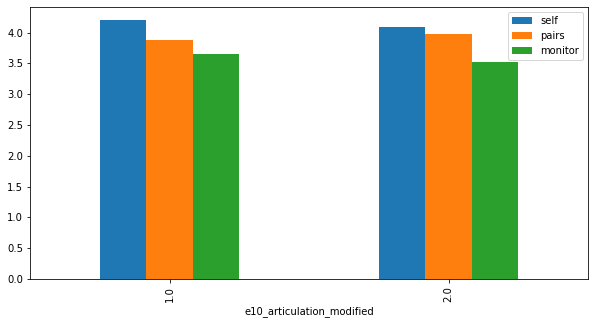

In [169]:
for interview_inputs in lista_screening_modified :
    interviews_360_avg_compare(interview_inputs)

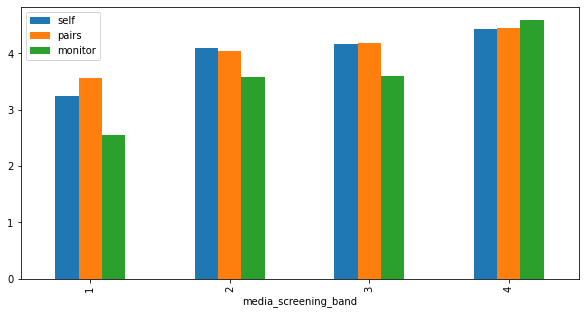

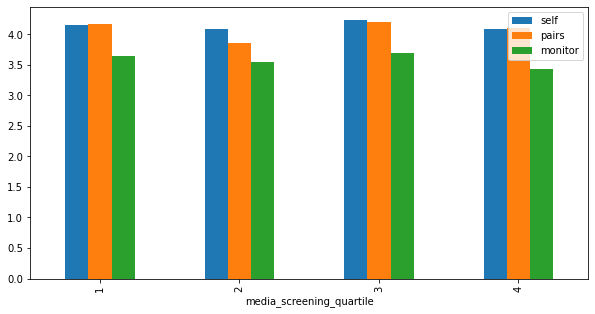

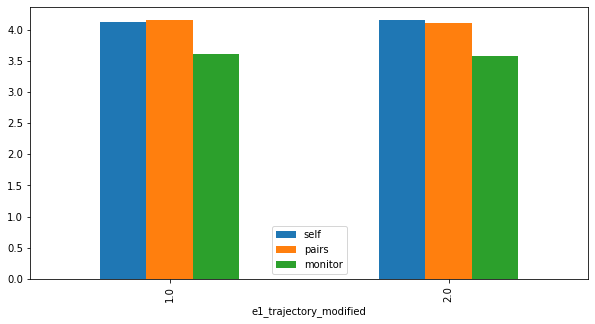

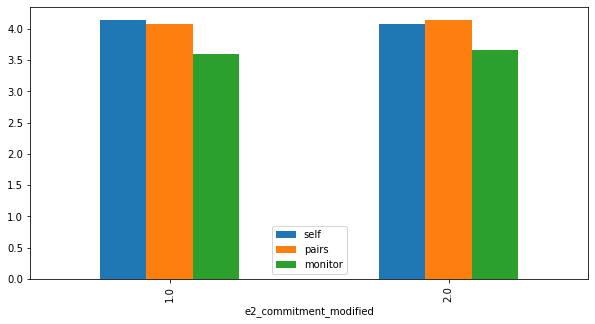

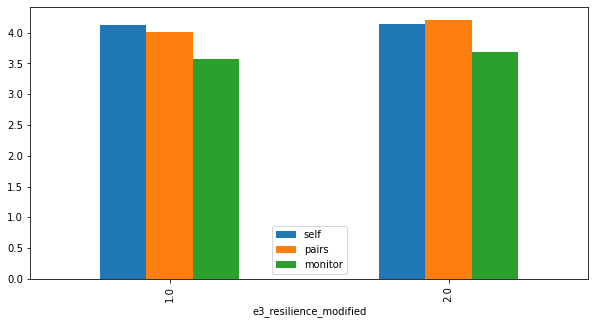

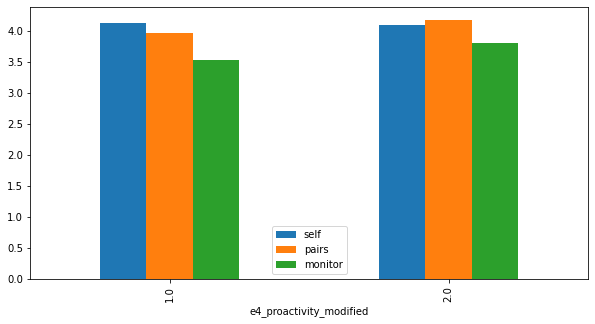

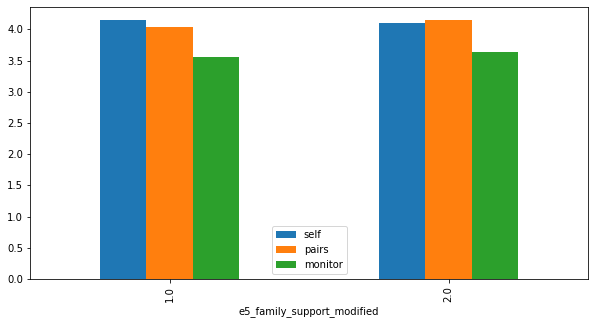

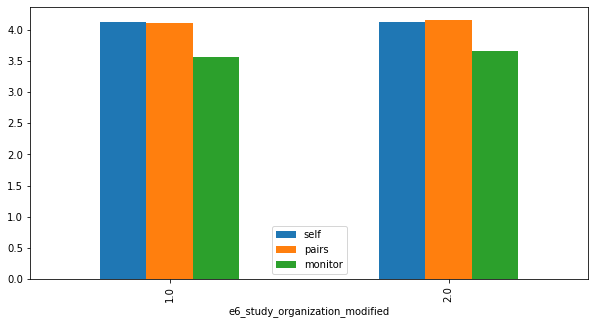

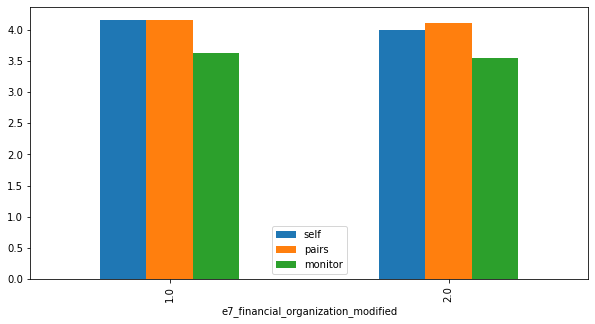

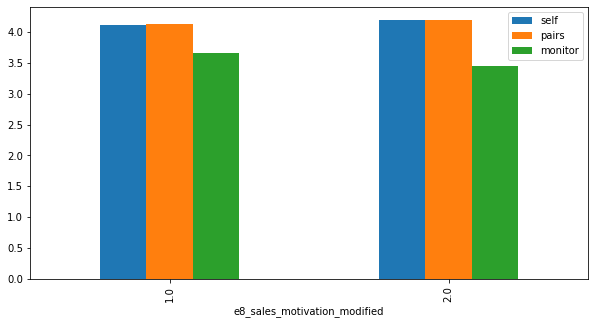

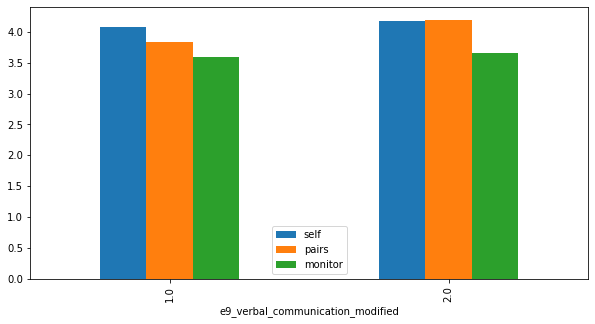

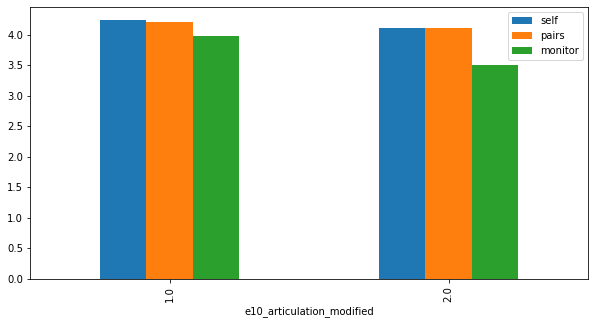

In [170]:
for interview_inputs in lista_screening_modified :
    interviews_360_median_compare(interview_inputs)

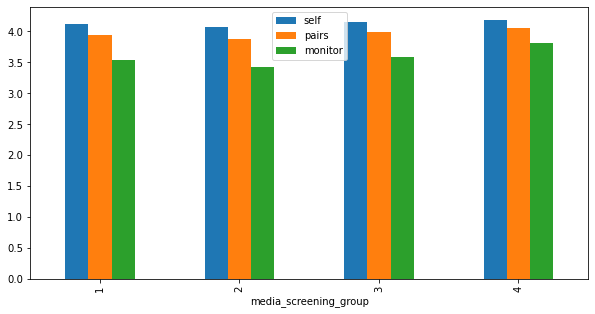

In [46]:
interviews_360_avg_compare("media_screening_group")

,self,pairs,monitor
media_screening_group,,,
1,4.150000,4.124333,3.640114
2,4.081667,3.905000,3.551020
3,4.260000,4.190000,3.652917
4,4.180000,4.109167,3.956522


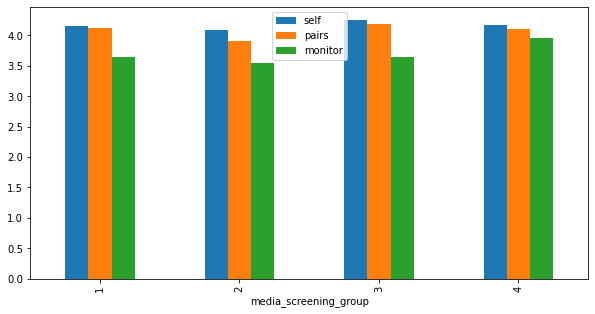

In [292]:
interviews_360_median_compare("media_screening_group")

,self,pairs,monitor
media_screening_group,,,
1,34,39,36
2,42,45,43
3,40,43,40
4,11,12,11


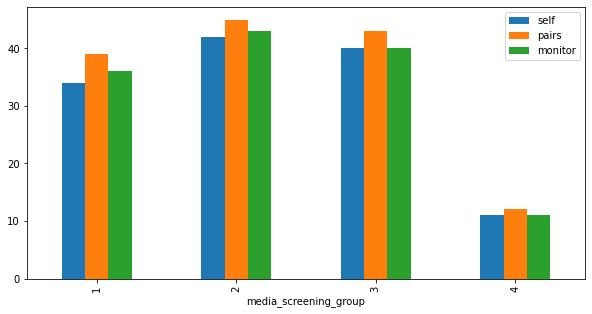

In [293]:
interviews_360_count_compare("media_screening_group")

## Correlations

In [174]:
assessment.head(2)

NameError: name 'assessment' is not defined

In [157]:
x = assessments_applicant\
.merge(turma3, on = 'applicant_id', how = 'left')\
.merge(irm_bands, on = 'applicant_id', how = 'left')
x = x[~x['monitor'].isnull()]

In [131]:
interview_inputs_list

['i6_formal_experience',
 'i7_informal_experience',
 'i9_extracurricular_courses']

In [163]:
for interview_inputs in interview_inputs_list :
    print(stats.f_oneway(x[interview_inputs], x['pairs']))

F_onewayResult(statistic=2675.1619088527264, pvalue=1.4517497893135775e-146)
F_onewayResult(statistic=2675.161908852723, pvalue=1.4517497893138163e-146)
F_onewayResult(statistic=2658.652255657567, pvalue=3.214027794458717e-146)


In [132]:
for interview_inputs in interview_inputs_list :
    print(stats.f_oneway(x[interview_inputs], x['monitor']))

F_onewayResult(statistic=1380.5341859215118, pvalue=1.4681946328138162e-105)
F_onewayResult(statistic=1380.5341859215118, pvalue=1.4681946328138162e-105)
F_onewayResult(statistic=1344.4899674230926, pvalue=2.5933085699176947e-104)


In [129]:
lista_screening

['media_screening_band',
 'e1_trajectory',
 'e2_commitment',
 'e3_resilience',
 'e4_proactivity',
 'e5_family_support',
 'e6_study_organization',
 'e7_financial_organization',
 'e8_sales_motivation',
 'e9_verbal_communication',
 'e10_articulation']

In [164]:
for interview_inputs in lista_screening :
    print(stats.f_oneway(x[interview_inputs], x['pairs']))

F_onewayResult(statistic=536.7726393105157, pvalue=2.0790824694054968e-67)
F_onewayResult(statistic=349.59175662085914, pvalue=2.0751544496052096e-51)
F_onewayResult(statistic=745.015225285919, pvalue=2.2478046159485013e-81)
F_onewayResult(statistic=669.2478040739364, pvalue=1.1886247051426944e-76)
F_onewayResult(statistic=600.0705693750538, pvalue=5.35038353304815e-72)
F_onewayResult(statistic=571.6208620122318, pvalue=5.610278900554314e-70)
F_onewayResult(statistic=379.11373712897426, pvalue=3.1687089311736386e-54)
F_onewayResult(statistic=519.9143583353731, pvalue=3.9822336961090114e-66)
F_onewayResult(statistic=514.5287701535591, pvalue=1.036211711772433e-65)
F_onewayResult(statistic=797.8566588738416, pvalue=1.8179663542002493e-84)
F_onewayResult(statistic=388.7008565961803, pvalue=4.1056537136537985e-55)
F_onewayResult(statistic=320.71928809401106, pvalue=1.5916228677580193e-48)


In [ ]:
e1_trajectory

In [160]:
for interview_inputs in lista_screening :
    print(stats.f_oneway(x[interview_inputs], x['monitor']))

F_onewayResult(statistic=211.8334277334849, pvalue=3.097967809343206e-36)
F_onewayResult(statistic=167.8108963059062, pvalue=1.7979864987630452e-30)
F_onewayResult(statistic=317.34368975977975, pvalue=3.5328004549255746e-48)
F_onewayResult(statistic=271.2421710398159, pvalue=3.0449680245703062e-43)
F_onewayResult(statistic=249.56678938678473, pvalue=8.883505635728175e-41)
F_onewayResult(statistic=235.64399368422727, pvalue=3.852802792735636e-39)
F_onewayResult(statistic=146.89250705910356, pvalue=1.5722063414842361e-27)
F_onewayResult(statistic=203.2483025718936, pvalue=3.7438661955179324e-35)
F_onewayResult(statistic=212.7007550805695, pvalue=2.414330508646367e-36)
F_onewayResult(statistic=338.6463442865287, pvalue=2.4819967540259843e-50)
F_onewayResult(statistic=138.55365940908732, pvalue=2.5701032998427838e-26)
F_onewayResult(statistic=97.38642140033113, pvalue=6.086288665762037e-20)


In [161]:
lista_screening_modified

['media_screening_band',
 'media_screening_quartile',
 'e1_trajectory_modified',
 'e2_commitment_modified',
 'e3_resilience_modified',
 'e4_proactivity_modified',
 'e5_family_support_modified',
 'e6_study_organization_modified',
 'e7_financial_organization_modified',
 'e8_sales_motivation_modified',
 'e9_verbal_communication_modified',
 'e10_articulation_modified']

In [162]:
for interview_inputs in lista_screening_modified :
    print(stats.f_oneway(x[interview_inputs], x['monitor']))

F_onewayResult(statistic=211.8334277334849, pvalue=3.097967809343206e-36)
F_onewayResult(statistic=167.8108963059062, pvalue=1.7979864987630452e-30)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)


<AxesSubplot:>

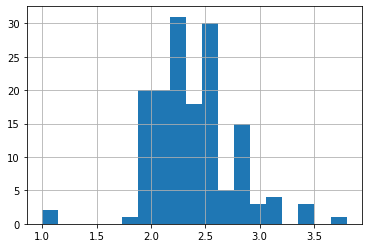

In [30]:
irm_bands['media_screening'].hist(bins = 19)

In [31]:
print(x['media_screening'].corr(x['monitor']))

0.13694431744136273


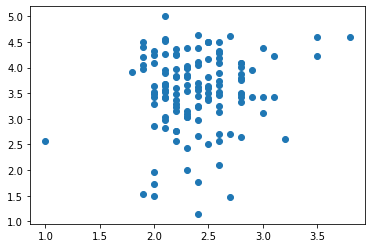

In [306]:
plt.scatter(x['media_screening'], x['monitor'])
plt.show()

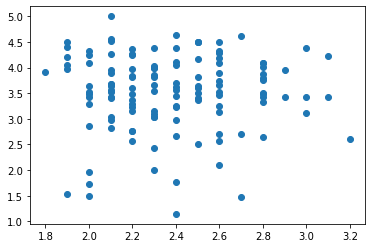

In [307]:
plt.scatter(x[(x['media_screening'] >= 1.7)&(x['media_screening'] <= 3.3)]['media_screening'], x[(x['media_screening'] >= 1.7)&(x['media_screening'] <= 3.3)]['monitor'])
plt.show()

# vs Competences

## Query

In [368]:
%%bigquery irm_bands
with db as (
        # general info
        select applicant_id,
               case when student_id is not null then 1 else 0 end as student_created,
               subscription_uuid,
        # logic_test_score_band
               logic_test_score,
               case when logic_test_score >= 64.28 then "5.alto"
                    when logic_test_score >= 58.85 then "4.medio-alto"
                    when logic_test_score >= 42.85 then "3.medio"
                    when logic_test_score >= 30 then "2.medio-baixo"
                    when logic_test_score >= 0 then "1.baixo"
                    else null end as logic_test_score_band,
        # sales_cs_adhesion_score_band
               sales_cs_adhesion_score,
               cast(sales_cs_adhesion_score/10 as int)*10 as sales_cs_adhesion_score_band,
        # experience
               case when i6_formal_experience is null then 0 else i6_formal_experience end as i6_formal_experience,
               case when i7_informal_experience is null then 0 else i7_informal_experience end as i7_informal_experience,
               case when i9_extracurricular_courses is null then 0 else i9_extracurricular_courses end as i9_extracurricular_courses,
               case when i10_sales_experience is null then 0 else i10_sales_experience end as i10_sales_experience,
        # media_screening
                case when interviewed = True then
                (case when e1_trajectory is null then 1 else e1_trajectory end
                + case when e2_commitment is null then 1 else e2_commitment end
                + case when e3_resilience is null then 1 else e3_resilience end
                + case when e4_proactivity is null then 1 else e4_proactivity end
                + case when e5_family_support is null then 1 else e5_family_support end
                + case when e6_study_organization is null then 1 else e6_study_organization end
                + case when e7_financial_organization is null then 1 else e7_financial_organization end
                + case when e8_sales_motivation is null then 1 else e8_sales_motivation end
                + case when e9_verbal_communication is null then 1 else e9_verbal_communication end
                + case when e10_articulation is null then 1 else e10_articulation end)/10
                else null end as media_screening,
    
        # media_screening
                case when interviewed = True then
                (case when e3_resilience is null then 1 else e3_resilience end
                + case when e6_study_organization is null then 1 else e6_study_organization end
                + case when e8_sales_motivation is null then 1 else e8_sales_motivation end
                + case when e9_verbal_communication is null then 1 else e9_verbal_communication end)/4
                else null end as media_screening_main,
    
        # screening components
                case when e1_trajectory is null then 1 else e1_trajectory end as e1_trajectory,
                case when e2_commitment is null then 1 else e2_commitment end as e2_commitment,
                case when e3_resilience is null then 1 else e3_resilience end as e3_resilience,
                case when e4_proactivity is null then 1 else e4_proactivity end as e4_proactivity,
                case when e5_family_support is null then 1 else e5_family_support end as e5_family_support,
                case when e6_study_organization is null then 1 else e6_study_organization end as e6_study_organization,
                case when e7_financial_organization is null then 1 else e7_financial_organization end as e7_financial_organization,
                case when e8_sales_motivation is null then 1 else e8_sales_motivation end as e8_sales_motivation,
                case when e9_verbal_communication is null then 1 else e9_verbal_communication end as e9_verbal_communication,
                case when e10_articulation is null then 1 else e10_articulation end as e10_articulation,
            
        # screening components - modified 1/2(low) & 3/4(high)
                cast(e1_trajectory/2 as int) as e1_trajectory_modified,
                cast(e2_commitment/2 as int) as e2_commitment_modified,
                cast(e3_resilience/2 as int) as e3_resilience_modified,
                cast(e4_proactivity/2 as int) as e4_proactivity_modified,
                cast(e5_family_support/2 as int) as e5_family_support_modified,
                cast(e6_study_organization/2 as int) as e6_study_organization_modified,
                cast(e7_financial_organization/2 as int) as e7_financial_organization_modified,
                cast(e8_sales_motivation/2 as int) as e8_sales_motivation_modified,
                cast(e9_verbal_communication/2 as int) as e9_verbal_communication_modified,
                cast(e10_articulation/2 as int) as e10_articulation_modified,
        # reference_points_gp1
                (case when i6_formal_experience is null then 0 else i6_formal_experience end
                 + case when i7_informal_experience is null then 0 else i7_informal_experience end 
                 + case when i9_extracurricular_courses is null then 0 else i9_extracurricular_courses end) as reference_points_gp1,
        # experience_points_gp2
                (case when i6_formal_experience = 1 then 2
                      when i7_informal_experience = 1 then 1
                      else 0 end 
                 + case when i9_extracurricular_courses is null then 0 else i9_extracurricular_courses end 
                 + case when i10_sales_experience is null then 0 else i10_sales_experience end) as experience_points_gp2
        , 1 as aux_count
        from `galena-web.inclusion.interview_results_model`
        )
        
select db.*,
       case when 
                 (e1_trajectory = 4) or
                 (e2_commitment = 4) or
                 (e3_resilience = 4) or
                 (e4_proactivity = 4) or
                 (e5_family_support = 4) or
                 (e6_study_organization = 4) or
                 (e7_financial_organization = 4) or
                 (e8_sales_motivation = 4) or
                 (e9_verbal_communication = 4) or
                 (e10_articulation = 4)
       then 1 else 0 end as distinction_any,

       case when 
                 # (e1_trajectory = 4) or
                 # (e2_commitment = 4) or
                 (e3_resilience = 4) or
                 # (e4_proactivity = 4) or
                 # (e5_family_support = 4) or
                 (e6_study_organization = 4) or
                 # (e7_financial_organization = 4) or
                 (e8_sales_motivation = 4) or
                 (e9_verbal_communication = 4)
                 # or (e10_articulation = 4)
       then 1 else 0 end as distinction_main,


####################################################################################################


       case when (e3_resilience = 4) or
                 (e6_study_organization = 4) or
                 (e8_sales_motivation = 4) or
                 (e9_verbal_communication = 4)
            then 'distinction_3_6_8_9'
            when (e2_commitment = 1) or
                 (e7_financial_organization = 1)
            then 'low_grade_2_7'
            else 'other' end as group_grades,

####################################################################################################


       case when e3_resilience = 4 then 1 else 0 end +
       case when e6_study_organization = 4 then 1 else 0 end +
       case when e8_sales_motivation = 4 then 1 else 0 end +
       case when e9_verbal_communication = 4 then 1 else 0 end
       as distinction_main_count,
    
    
    
       case when e1_trajectory = 4 then 1 else 0 end +
       case when e2_commitment = 4 then 1 else 0 end +
       case when e3_resilience = 4 then 1 else 0 end +
       case when e4_proactivity = 4 then 1 else 0 end +
       case when e5_family_support = 4 then 1 else 0 end +
       case when e6_study_organization = 4 then 1 else 0 end +
       case when e7_financial_organization = 4 then 1 else 0 end +
       case when e8_sales_motivation = 4 then 1 else 0 end +
       case when e9_verbal_communication = 4 then 1 else 0 end +
       case when e10_articulation = 4 then 1 else 0 end
       as distinction_count,


       case when 
                 (e1_trajectory = 1) or
                 (e2_commitment = 1) or
                 (e3_resilience = 1) or
                 (e4_proactivity = 1) or
                 (e5_family_support = 1) or
                 (e6_study_organization = 1) or
                 (e7_financial_organization = 1) or
                 (e8_sales_motivation = 1) or
                 (e9_verbal_communication = 1) or
                 (e10_articulation = 1)
       then 1 else 0 end as distinction_anti,


       case when 
                 (e1_trajectory = 4) or
                 (e2_commitment = 4) or
                 # (e3_resilience = 4) or
                 (e4_proactivity = 4) or
                 (e5_family_support = 4) or
                 # (e6_study_organization = 4) or
                 (e7_financial_organization = 4) or
                 # (e8_sales_motivation = 4) or
                 # (e9_verbal_communication = 4) or
                 (e10_articulation = 4)
       then 1 else 0 end as distinction_2,
       case when media_screening <= 2.1 then 1
            when media_screening <= 2.4 then 2
            when media_screening <= 2.8 then 3
        else 4 end as media_screening_quartile,
        cast(media_screening as int) as media_screening_band,
        cast(media_screening_main as int) as media_screening_main_band
from db 
inner join (select distinct applicant_id 
            from `galena-web.inclusion.applicant_funnel_snapshot` 
            where in_profile = 1 
            # and interviewed = True 
            and student_created_at is not null) in_profile
on db.applicant_id = in_profile.applicant_id


Downloading: 100%|████████████████████████████████████████████| 217/217 [00:01<00:00, 140.03rows/s]


In [369]:
irm_bands = irm_bands.drop_duplicates()

## Analysis

In [351]:
irm_bands.count()

applicant_id                 197
student_created              197
subscription_uuid            197
logic_test_score             195
logic_test_score_band        195
                            ... 
distinction_anti             197
distinction_2                197
media_screening_quartile     197
media_screening_band         153
media_screening_main_band    153
Length: 46, dtype: int64

In [355]:
entrevistas_t2.head(2)

,personal_email,e9_verbal_communication,e10_articulation,e1_trajectory,e3_resilience,e5_family_support,e7_financial_organization,e6_study_organization,e8_sales_motivation
0,tiphannymaisaga@hotmail.com,3,3,3,2,2,2,3,2
1,gl3787377@gmail.com,2,3,2,3,2,2,2,3


In [280]:
df_applicant_unique = assessments_applicant\
.merge(turma3, on = 'applicant_id', how = 'inner')\
.merge(irm_bands, on = 'applicant_id', how = 'inner')

In [277]:
df_applicant = assessments_competence\
.merge(turma3, on = 'applicant_id', how = 'inner')\
.merge(irm_bands, on = 'applicant_id', how = 'inner')

### Cruzamento componentes vs avaliação 360

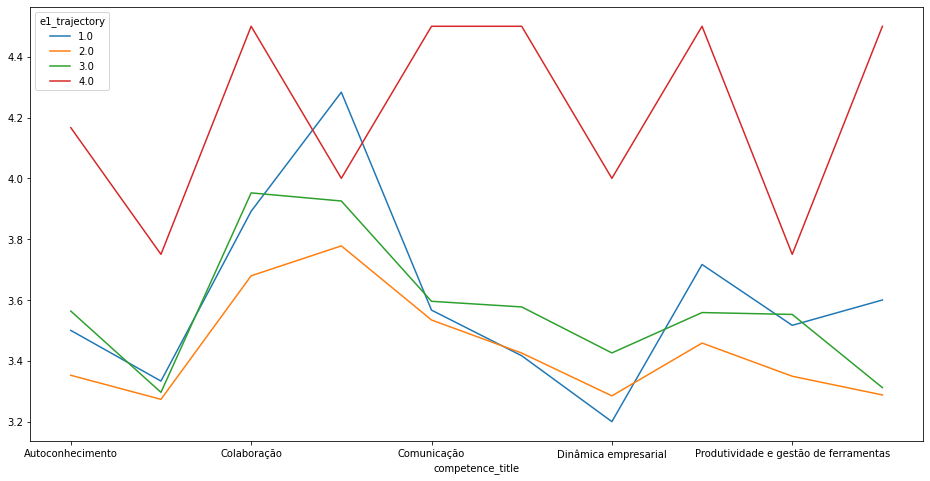

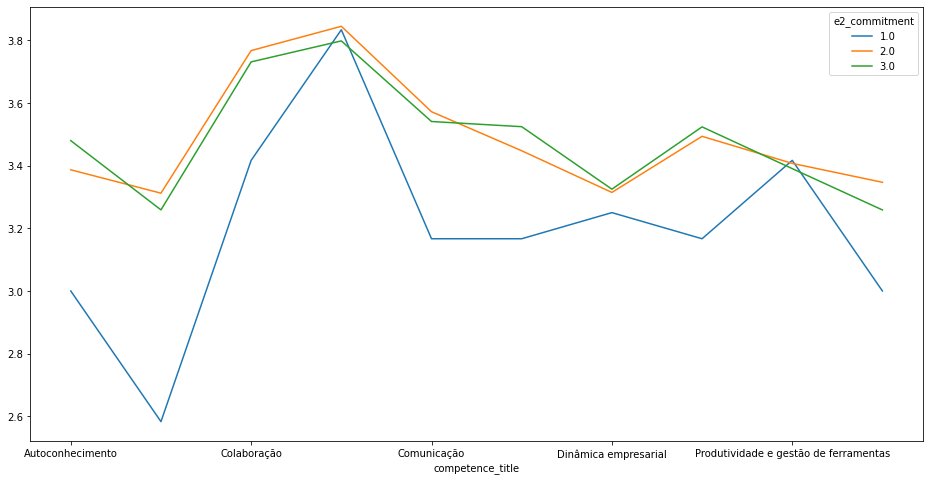

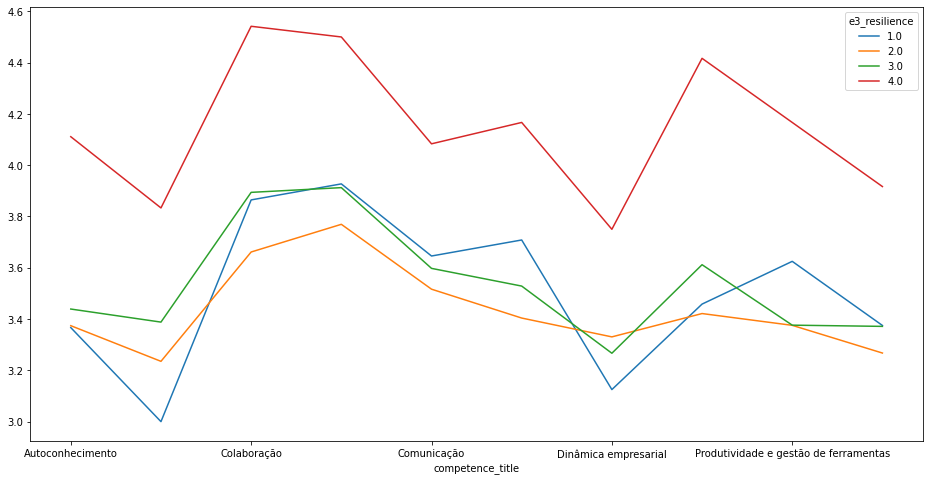

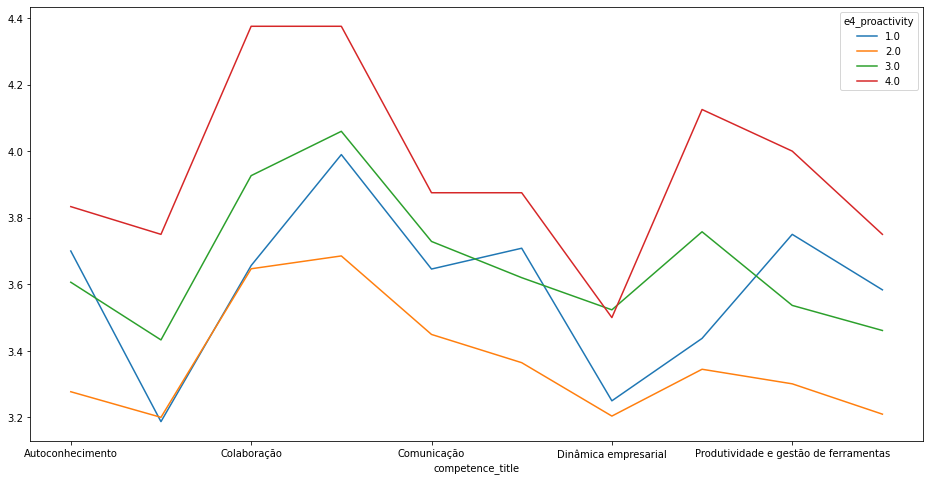

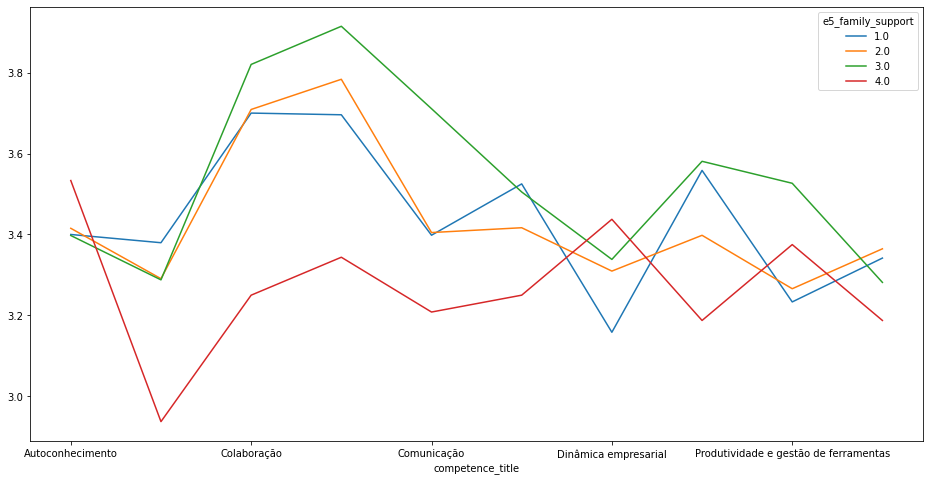

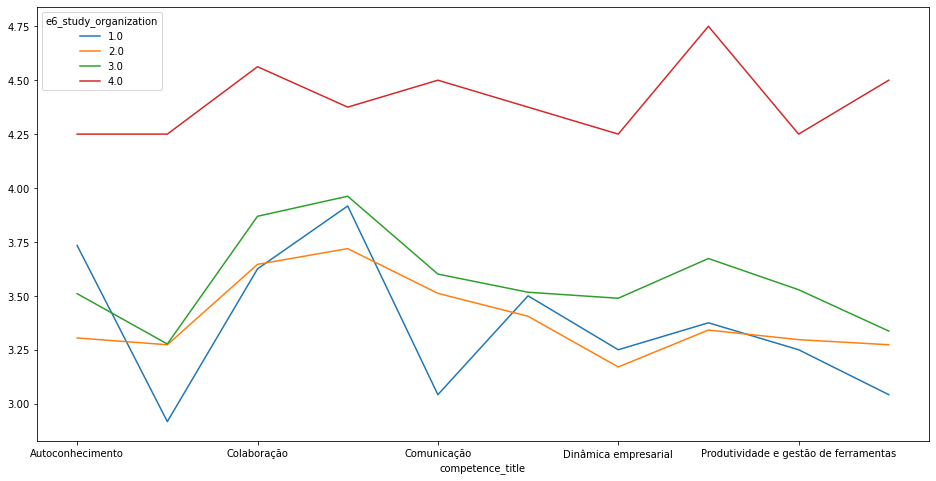

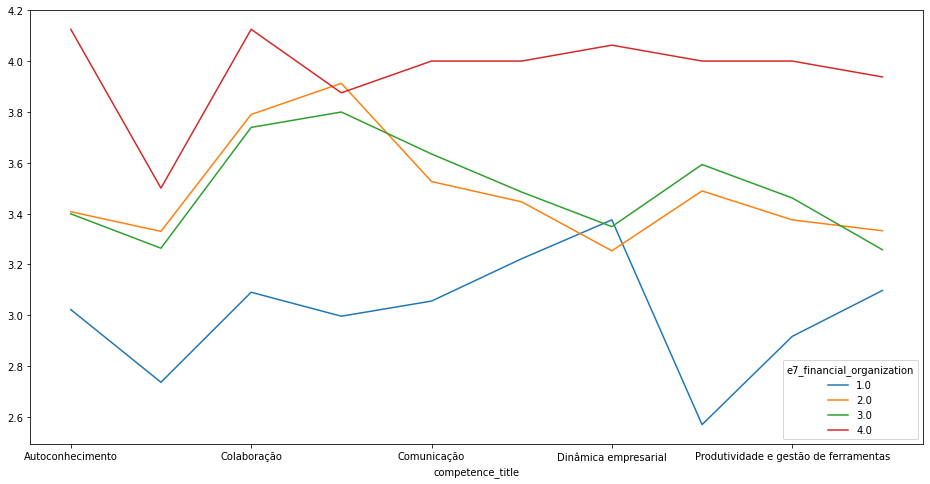

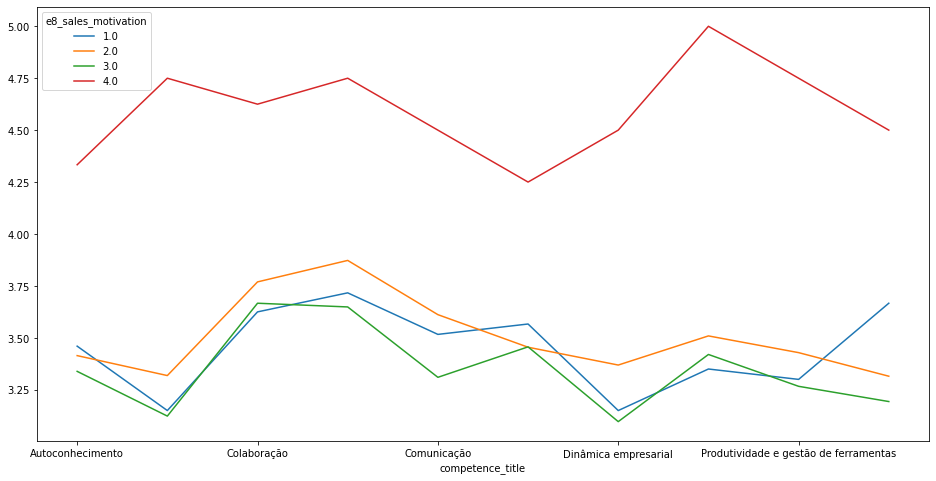

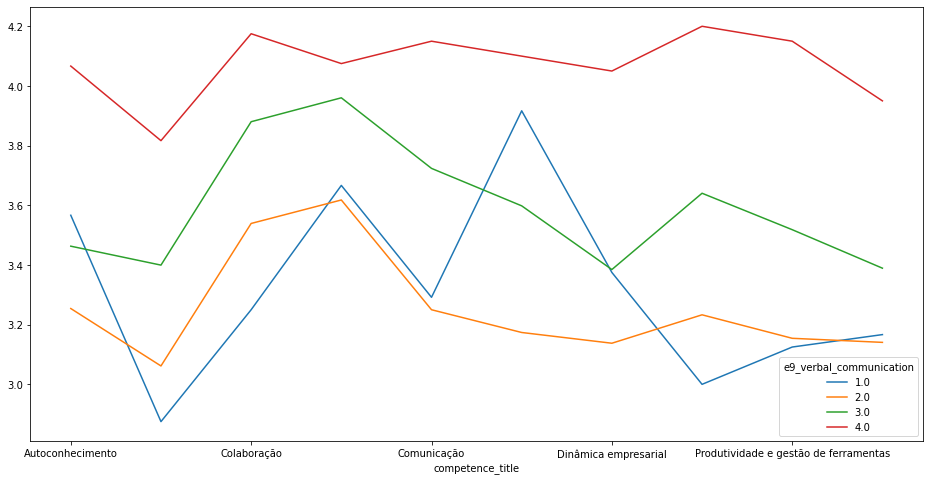

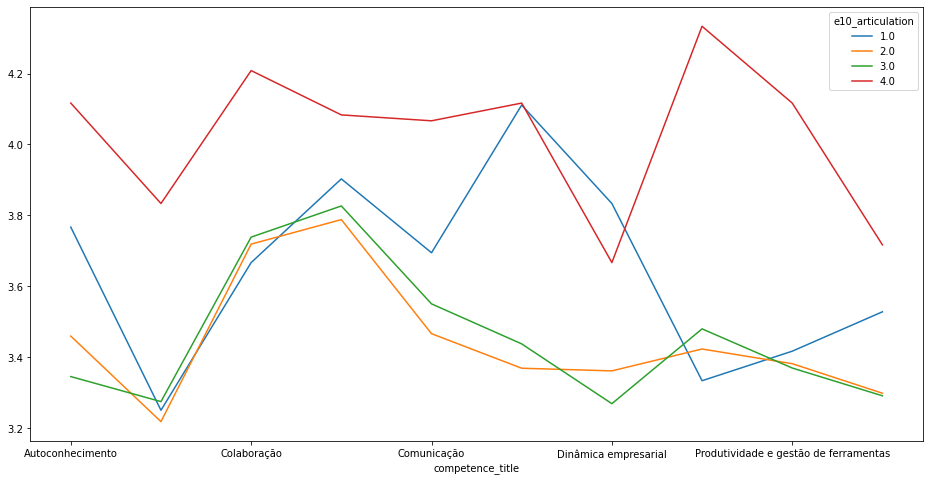

In [370]:
lista_screening = ["e1_trajectory",
                   "e2_commitment",
                   "e3_resilience",
                   "e4_proactivity",
                   "e5_family_support",
                   "e6_study_organization",
                   "e7_financial_organization",
                   "e8_sales_motivation",
                   "e9_verbal_communication",
                   "e10_articulation"]

for input_column in lista_screening:
    competences_func(input_column)

### Distinction/Low grade/Other groups

In [293]:
df_applicant.columns

Index(['applicant_id', 'competence_code', 'competence_title', 'pairs', 'self',
       'monitor', 'pairs_monitor', 'overall', 'group', 'student_created',
       'subscription_uuid', 'logic_test_score', 'logic_test_score_band',
       'sales_cs_adhesion_score', 'sales_cs_adhesion_score_band',
       'i6_formal_experience', 'i7_informal_experience',
       'i9_extracurricular_courses', 'i10_sales_experience', 'media_screening',
       'media_screening_main', 'e1_trajectory', 'e2_commitment',
       'e3_resilience', 'e4_proactivity', 'e5_family_support',
       'e6_study_organization', 'e7_financial_organization',
       'e8_sales_motivation', 'e9_verbal_communication', 'e10_articulation',
       'e1_trajectory_modified', 'e2_commitment_modified',
       'e3_resilience_modified', 'e4_proactivity_modified',
       'e5_family_support_modified', 'e6_study_organization_modified',
       'e7_financial_organization_modified', 'e8_sales_motivation_modified',
       'e9_verbal_communication_modifi

In [371]:
df_applicant_unique[['applicant_id', 'classification_2_3']].groupby('classification_2_3').count()

,applicant_id
classification_2_3,
equal,13
mostly_2,82
mostly_3,42


In [372]:
df_applicant_unique[['classification_2_3', 'media_screening']].groupby('classification_2_3').mean()

,media_screening
classification_2_3,
equal,2.430769
mostly_2,2.174390
mostly_3,2.804762


<AxesSubplot:xlabel='competence_title'>

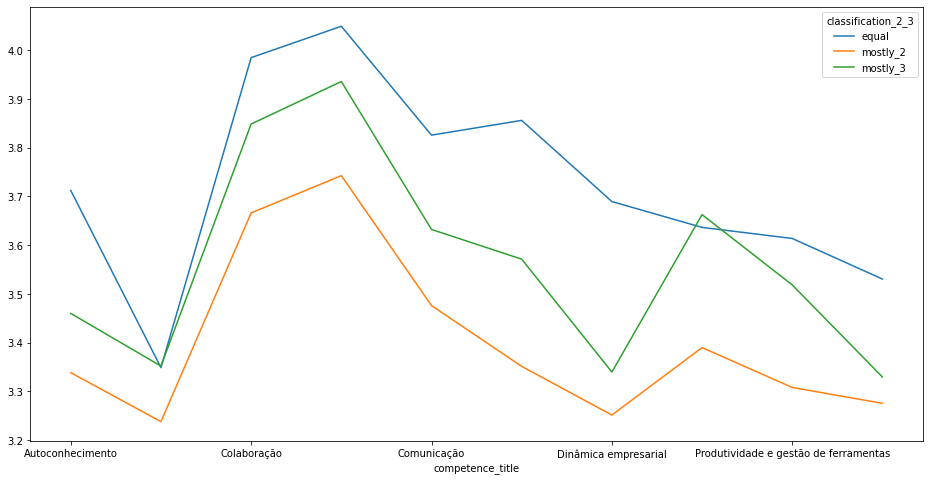

In [ ]:
df_applicant[['monitor', 'competence_title', 'classification_2_3']]\
.groupby(['classification_2_3', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'classification_2_3', values = 'monitor').plot(figsize = (16, 8))

<AxesSubplot:xlabel='competence_title'>

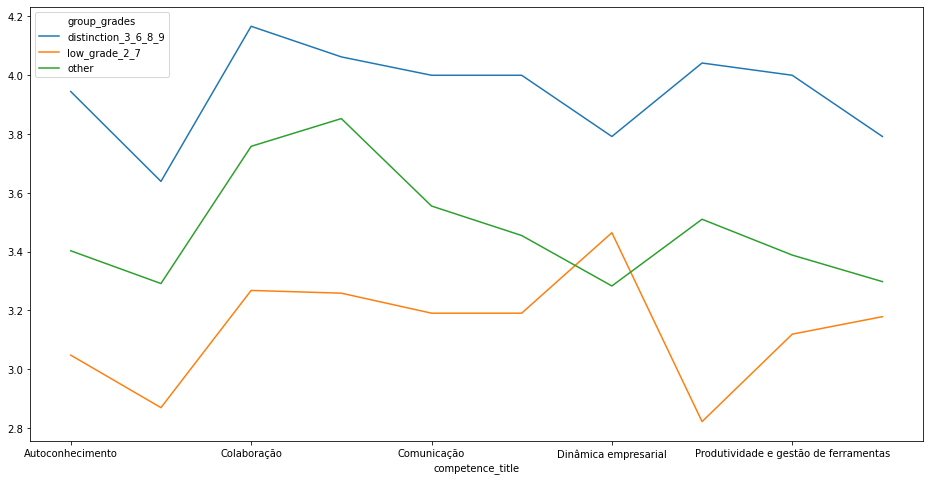

In [307]:
df_applicant[['monitor', 'competence_title', 'group_grades']]\
.groupby(['group_grades', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'group_grades', values = 'monitor').plot(figsize = (16, 8))

In [274]:
df_applicant[['monitor', 'competence_title', 'group_grades']]\
.groupby(['group_grades', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'group_grades', values = 'monitor').to_csv('group_grades.csv')

In [273]:
df_applicant[['applicant_id', 'group_grades']].drop_duplicates().groupby('group_grades').count()

,applicant_id
group_grades,
distinction_3_6_8_9,7
low_grade_2_7,7
other,122


In [269]:
df_applicant[['competence_title']].drop_duplicates().sort_values('competence_title')

,competence_title
4,Autoconhecimento
2,Capacidade analítica
5,Colaboração
1,Comprometimento
8,Comunicação
0,Desenvolvimento
9,Dinâmica empresarial
7,Proatividade
3,Produtividade e gestão de ferramentas
6,Resiliência


In [209]:
df_applicant[['group_grades', 'applicant_id']].drop_duplicates().groupby('group_grades').count()

,applicant_id
group_grades,
distinction_main,7
low_grade_main,7
other,122


### #Distinctions

<AxesSubplot:xlabel='competence_title'>

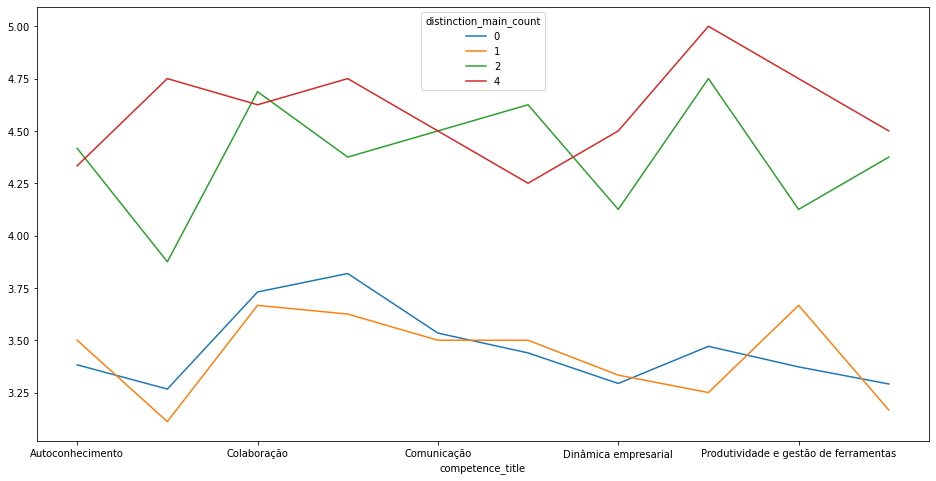

In [ ]:
df_applicant[['monitor', 'competence_title', 'distinction_main_count']]\
.groupby(['distinction_main_count', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'distinction_main_count', values = 'monitor').plot(figsize = (16, 8))

### Media screening - Quartis

<AxesSubplot:xlabel='competence_title'>

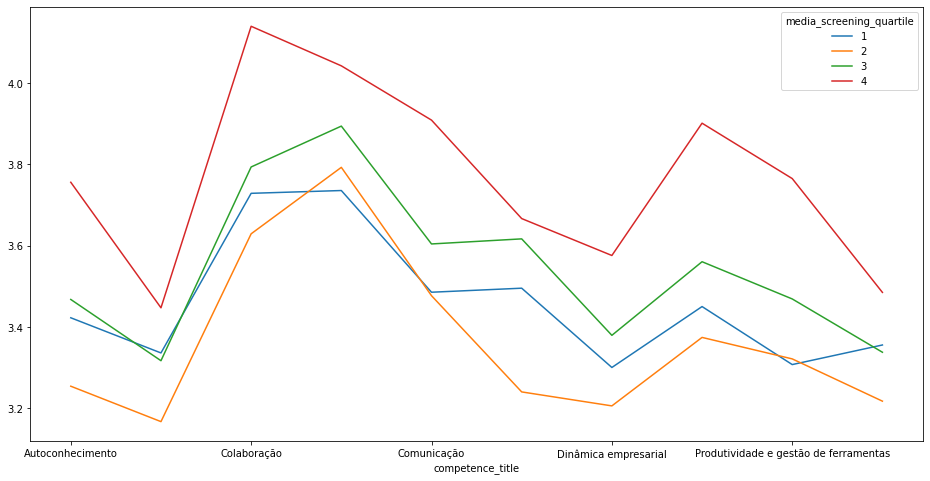

In [255]:
df_applicant[['monitor', 'competence_title', 'media_screening_quartile']]\
.groupby(['media_screening_quartile', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'media_screening_quartile', values = 'monitor').plot(figsize = (16, 8))

### Sandbox

<AxesSubplot:xlabel='competence_title'>

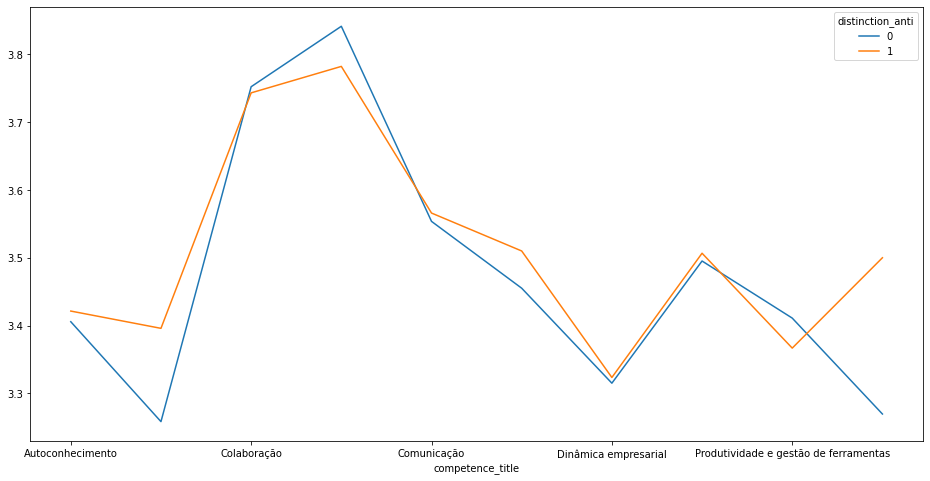

In [86]:
df_applicant[['monitor', 'competence_title', 'distinction_anti']]\
.groupby(['distinction_anti', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'distinction_anti', values = 'monitor').plot(figsize = (16, 8))

In [141]:
df_applicant[['monitor', 'competence_title', 'distinction_anti']]\
.groupby(['distinction_anti', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'distinction_anti', values = 'monitor')

distinction_anti,0,1
competence_title,,
Autoconhecimento,3.405609,3.421333
Capacidade analítica,3.258170,3.395833
Colaboração,3.752381,3.743333
Comprometimento,3.841587,3.782381
Comunicação,3.553686,3.565972
Desenvolvimento,3.455065,3.510000
Dinâmica empresarial,3.314904,3.323333
Proatividade,3.495192,3.506667
Produtividade e gestão de ferramentas,3.410948,3.366667


<AxesSubplot:xlabel='competence_title'>

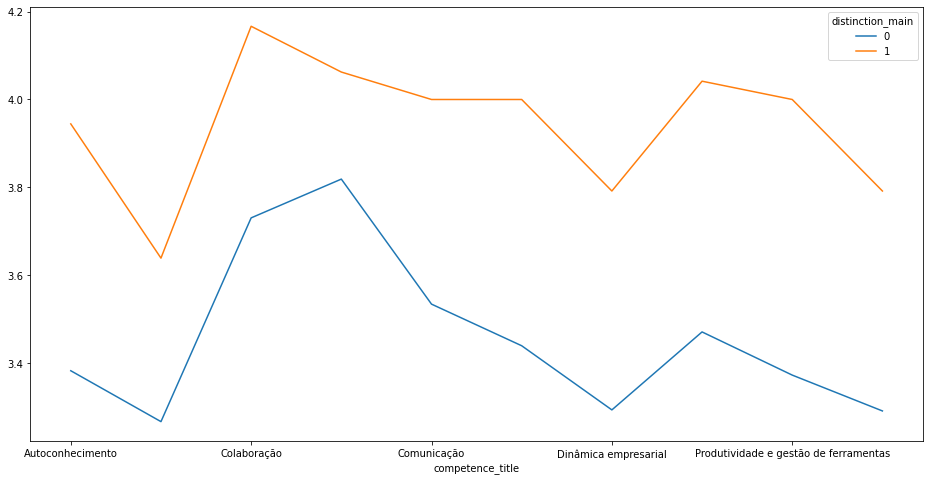

In [301]:
df_applicant[['monitor', 'competence_title', 'distinction_main']]\
.groupby(['distinction_main', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'distinction_main', values = 'monitor').plot(figsize = (16, 8))

In [ ]:
df_applicant[df_applicant['distinction_main' == 1]][['monitor', 'competence_title', 'distinction_main']]\
.groupby(['distinction_main', 'competence_title']).mean().reset_index()\
.pivot(index = 'competence_title', columns = 'distinction_main', values = 'monitor').plot(figsize = (16, 8))

In [244]:
def competences_func(interview_inputs, competence_title) :
# # sample_control
#     sample_control = df_applicant\
#     .groupby([interview_inputs, 'competence_title']).applicant_id.count().reset_index()
#     sample_control = sample_control[sample_control['applicant_id'] >= 10]
#     sample_control = sample_control[[interview_inputs]]

# plot/return
    final_df = df_applicant[['self', 'pairs', 'monitor', 'competence_title', interview_inputs]].groupby([interview_inputs, 'competence_title']).mean() 
    final_df.plot(figsize = (10, 5), kind = 'bar')
    # return(final_df)


In [45]:
def competences_func(input_column) :
    final_df = df_applicant[['monitor', 'competence_title', input_column]]\
    .groupby([input_column, 'competence_title']).mean().reset_index()\
    .pivot(index = 'competence_title', columns = input_column, values = 'monitor').plot(figsize = (16, 8))

In [ ]:
# inputs
lista_screening = ["e1_trajectory",
                   "e2_commitment",
                   "e3_resilience",
                   "e4_proactivity",
                   "e5_family_support",
                   "e6_study_organization",
                   "e7_financial_organization",
                   "e8_sales_motivation",
                   "e9_verbal_communication",
                   "e10_articulation"]


lista_screening_modified = ["media_screening_band",
                            "media_screening_quartile",
                            "e1_trajectory_modified",
                            "e2_commitment_modified",
                            "e3_resilience_modified",
                            "e4_proactivity_modified",
                            "e5_family_support_modified",
                            "e6_study_organization_modified",
                            "e7_financial_organization_modified",
                            "e8_sales_motivation_modified",
                            "e9_verbal_communication_modified",
                            "e10_articulation_modified"]

list_tests = ['logic_test_score_band', 
              'sales_cs_adhesion_score_band',
              'media_screening_band']

interview_inputs_list = ['i6_formal_experience',
                         'i7_informal_experience',
                         'i9_extracurricular_courses']

interview_inputs_list_2 = ['group',
                           'i6_formal_experience',
                           'i7_informal_experience',
                           'i9_extracurricular_courses']

# output
list_360_bands = ['pairs_band',
                  'self_band',
                  'monitor_band',
                  'pairs_monitor_band',
                  'overall_band']

list_360 = ['pairs',
            'self',
            'monitor',
            'pairs_monitor',
            'overall']


In [ ]:
for interview_inputs in lista_screening :
    for competence_title in assessments_competence['competence_title'] :
        competences_func(interview_inputs, competence_title)

/Users/rodrigoeji/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
